In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input, layers
from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from spektral.layers import GCNConv

import keras_tuner as kt
from BaselinePrerocess import gcn_process
from graph import graph_topology
from baselines.gcn import gcn

2023-07-22 00:29:52.020080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 00:29:53.674412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
dropout = 0
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = gcn_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_X_mask = train_X_mask[:, :, :n_hours]
val_X_mask = val_X_mask[:, :, :n_hours]
test_X_mask = test_X_mask[:, :, :n_hours]

In [7]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 14, 72) (9634, 14, 72) (19268, 14, 72) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [8]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58


In [9]:
print(train_adj_mat.shape, val_adj_mat.shape, test_adj_mat.shape)

(77069, 14, 14) (9634, 14, 14) (19268, 14, 14)


### Model

In [11]:
n_nodes = train_adj_mat.shape[-1]
n_timesteps = train_X_mask.shape[-1]

In [12]:
# n_nodes, n_timesteps, gcn1, gcn2, lstm_unit
model, GCNConv = gcn(gcn1=gcn_unit1,
                     gcn2=gcn_unit2,
                     n_nodes=n_nodes,
                     n_timesteps=n_timesteps,
                     lstm_unit=lstm_units,
                     dropout=dropout,
                     masked_value=masked_value
                    )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 14, 72)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 14, 14)]             0         []                            
                                                                                                  
 gcn_conv_2 (GCNConv)        (None, 14, 32)               2336      ['input_4[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 gcn_conv_3 (GCNConv)        (None, 14, 16)               528       ['gcn_conv_2[0][0]',    

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/gcn_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_X_mask, train_adj_mat], train_ws_y,
          validation_data=([test_X_mask, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 00:32:16.710568: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0d9401b030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 00:32:16.710623: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 00:32:16.720720: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 00:32:16.951844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 00:32:17.368660: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.10513, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 10s - loss: 0.1354 - mae: 0.1862 - val_loss: 0.0188 - val_mae: 0.1051 - 10s/epoch - 64ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.10513 to 0.07130, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 0.0076 - mae: 0.0637 - val_loss: 0.0084 - val_mae: 0.0713 - 4s/epoch - 24ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.07130 to 0.05977, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 0.0036 - mae: 0.0453 - val_loss: 0.0058 - val_mae: 0.0598 - 4s/epoch - 25ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05977 to 0.05532, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 0.0025 - mae: 0.0380 - val_loss: 0.0049 - val_mae: 0.0553 - 4s/epoch - 25ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05532 to 0.05124, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 0.0021 - mae: 0.0345 - val_loss: 0.0042 - val_mae: 0.0512 - 4s/epoch - 25ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05124 to 0.04772, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/1

Epoch 41/3000

Epoch 41: val_mae improved from 0.02771 to 0.02758, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 3.4112e-04 - mae: 0.0128 - val_loss: 0.0013 - val_mae: 0.0276 - 4s/epoch - 25ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02758
151/151 - 4s - loss: 3.3465e-04 - mae: 0.0127 - val_loss: 0.0013 - val_mae: 0.0276 - 4s/epoch - 24ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.02758
151/151 - 4s - loss: 3.2938e-04 - mae: 0.0126 - val_loss: 0.0013 - val_mae: 0.0277 - 4s/epoch - 24ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.02758
151/151 - 4s - loss: 3.2541e-04 - mae: 0.0125 - val_loss: 0.0013 - val_mae: 0.0281 - 4s/epoch - 23ms/step
Epoch 45/3000

Epoch 45: val_mae improved from 0.02758 to 0.02755, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 3.2048e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0276 - 4s/epoch - 24ms/step
Epoch 46/3000

Epoch 46: val_mae improve


Epoch 84: val_mae did not improve from 0.02250
151/151 - 3s - loss: 2.2768e-04 - mae: 0.0100 - val_loss: 9.2875e-04 - val_mae: 0.0232 - 3s/epoch - 23ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.02250
151/151 - 3s - loss: 2.2546e-04 - mae: 0.0100 - val_loss: 8.9412e-04 - val_mae: 0.0227 - 3s/epoch - 23ms/step
Epoch 86/3000

Epoch 86: val_mae improved from 0.02250 to 0.02232, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 2.2315e-04 - mae: 0.0099 - val_loss: 8.7233e-04 - val_mae: 0.0223 - 4s/epoch - 24ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.02232
151/151 - 4s - loss: 2.2392e-04 - mae: 0.0099 - val_loss: 8.4606e-04 - val_mae: 0.0223 - 4s/epoch - 24ms/step
Epoch 88/3000

Epoch 88: val_mae improved from 0.02232 to 0.02203, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 2.2221e-04 - mae: 0.0099 - val_loss: 8.4928e-04 - val_mae: 0.0220 - 4s/epoch - 24ms/step
Epoch 89/3000

Epoch 89: val_mae d

151/151 - 4s - loss: 1.8727e-04 - mae: 0.0089 - val_loss: 6.6341e-04 - val_mae: 0.0195 - 4s/epoch - 24ms/step
Epoch 128/3000

Epoch 128: val_mae improved from 0.01955 to 0.01953, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 1.8617e-04 - mae: 0.0088 - val_loss: 6.7082e-04 - val_mae: 0.0195 - 4s/epoch - 24ms/step
Epoch 129/3000

Epoch 129: val_mae did not improve from 0.01953
151/151 - 4s - loss: 1.8604e-04 - mae: 0.0088 - val_loss: 6.8928e-04 - val_mae: 0.0197 - 4s/epoch - 24ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.01953
151/151 - 4s - loss: 1.8541e-04 - mae: 0.0088 - val_loss: 6.7529e-04 - val_mae: 0.0197 - 4s/epoch - 24ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.01953
151/151 - 4s - loss: 1.8561e-04 - mae: 0.0088 - val_loss: 6.8224e-04 - val_mae: 0.0197 - 4s/epoch - 24ms/step
Epoch 132/3000

Epoch 132: val_mae improved from 0.01953 to 0.01906, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 

151/151 - 4s - loss: 1.6826e-04 - mae: 0.0083 - val_loss: 6.0216e-04 - val_mae: 0.0182 - 4s/epoch - 24ms/step
Epoch 172/3000

Epoch 172: val_mae did not improve from 0.01783
151/151 - 4s - loss: 1.6709e-04 - mae: 0.0083 - val_loss: 5.8862e-04 - val_mae: 0.0180 - 4s/epoch - 24ms/step
Epoch 173/3000

Epoch 173: val_mae did not improve from 0.01783
151/151 - 4s - loss: 1.6703e-04 - mae: 0.0083 - val_loss: 5.8670e-04 - val_mae: 0.0181 - 4s/epoch - 24ms/step
Epoch 174/3000

Epoch 174: val_mae improved from 0.01783 to 0.01768, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 1.6735e-04 - mae: 0.0083 - val_loss: 5.6127e-04 - val_mae: 0.0177 - 4s/epoch - 24ms/step
Epoch 175/3000

Epoch 175: val_mae did not improve from 0.01768
151/151 - 4s - loss: 1.6679e-04 - mae: 0.0083 - val_loss: 5.9680e-04 - val_mae: 0.0183 - 4s/epoch - 24ms/step
Epoch 176/3000

Epoch 176: val_mae did not improve from 0.01768
151/151 - 4s - loss: 1.6653e-04 - mae: 0.0083 - val_loss: 5.8627e-04 -

151/151 - 4s - loss: 1.5706e-04 - mae: 0.0080 - val_loss: 5.3501e-04 - val_mae: 0.0173 - 4s/epoch - 24ms/step
Epoch 215/3000

Epoch 215: val_mae did not improve from 0.01678
151/151 - 4s - loss: 1.5648e-04 - mae: 0.0079 - val_loss: 5.2659e-04 - val_mae: 0.0171 - 4s/epoch - 24ms/step
Epoch 216/3000

Epoch 216: val_mae improved from 0.01678 to 0.01666, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 1.5649e-04 - mae: 0.0079 - val_loss: 4.9844e-04 - val_mae: 0.0167 - 4s/epoch - 25ms/step
Epoch 217/3000

Epoch 217: val_mae did not improve from 0.01666
151/151 - 4s - loss: 1.5738e-04 - mae: 0.0080 - val_loss: 5.2985e-04 - val_mae: 0.0171 - 4s/epoch - 24ms/step
Epoch 218/3000

Epoch 218: val_mae did not improve from 0.01666
151/151 - 4s - loss: 1.5609e-04 - mae: 0.0079 - val_loss: 5.3651e-04 - val_mae: 0.0173 - 4s/epoch - 24ms/step
Epoch 219/3000

Epoch 219: val_mae did not improve from 0.01666
151/151 - 4s - loss: 1.5552e-04 - mae: 0.0079 - val_loss: 5.1572e-04 -

Epoch 260/3000

Epoch 260: val_mae did not improve from 0.01586
151/151 - 4s - loss: 1.4968e-04 - mae: 0.0077 - val_loss: 5.2026e-04 - val_mae: 0.0168 - 4s/epoch - 24ms/step
Epoch 261/3000

Epoch 261: val_mae did not improve from 0.01586
151/151 - 3s - loss: 1.4872e-04 - mae: 0.0077 - val_loss: 4.7232e-04 - val_mae: 0.0161 - 3s/epoch - 23ms/step
Epoch 262/3000

Epoch 262: val_mae did not improve from 0.01586
151/151 - 4s - loss: 1.4847e-04 - mae: 0.0077 - val_loss: 4.7769e-04 - val_mae: 0.0162 - 4s/epoch - 24ms/step
Epoch 263/3000

Epoch 263: val_mae did not improve from 0.01586
151/151 - 4s - loss: 1.4994e-04 - mae: 0.0077 - val_loss: 5.2334e-04 - val_mae: 0.0169 - 4s/epoch - 24ms/step
Epoch 264/3000

Epoch 264: val_mae improved from 0.01586 to 0.01578, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 1.4911e-04 - mae: 0.0077 - val_loss: 4.5604e-04 - val_mae: 0.0158 - 4s/epoch - 24ms/step
Epoch 265/3000

Epoch 265: val_mae did not improve from 0.01578
151/15

151/151 - 4s - loss: 1.4417e-04 - mae: 0.0075 - val_loss: 4.6927e-04 - val_mae: 0.0160 - 4s/epoch - 24ms/step
Epoch 306/3000

Epoch 306: val_mae did not improve from 0.01541
151/151 - 3s - loss: 1.4396e-04 - mae: 0.0075 - val_loss: 4.6155e-04 - val_mae: 0.0159 - 3s/epoch - 23ms/step
Epoch 307/3000

Epoch 307: val_mae did not improve from 0.01541
151/151 - 4s - loss: 1.4417e-04 - mae: 0.0075 - val_loss: 4.7199e-04 - val_mae: 0.0161 - 4s/epoch - 25ms/step
Epoch 308/3000

Epoch 308: val_mae did not improve from 0.01541
151/151 - 4s - loss: 1.4321e-04 - mae: 0.0075 - val_loss: 4.9236e-04 - val_mae: 0.0163 - 4s/epoch - 24ms/step
Epoch 309/3000

Epoch 309: val_mae did not improve from 0.01541
151/151 - 4s - loss: 1.4373e-04 - mae: 0.0075 - val_loss: 4.9515e-04 - val_mae: 0.0165 - 4s/epoch - 24ms/step
Epoch 310/3000

Epoch 310: val_mae did not improve from 0.01541
151/151 - 4s - loss: 1.4345e-04 - mae: 0.0075 - val_loss: 4.5402e-04 - val_mae: 0.0157 - 4s/epoch - 25ms/step
Epoch 311/3000

Epoc

151/151 - 3s - loss: 1.3963e-04 - mae: 0.0074 - val_loss: 5.0444e-04 - val_mae: 0.0166 - 3s/epoch - 23ms/step
Epoch 353/3000

Epoch 353: val_mae did not improve from 0.01525
151/151 - 3s - loss: 1.3949e-04 - mae: 0.0074 - val_loss: 4.5503e-04 - val_mae: 0.0157 - 3s/epoch - 23ms/step
Epoch 354/3000

Epoch 354: val_mae did not improve from 0.01525
151/151 - 4s - loss: 1.3946e-04 - mae: 0.0074 - val_loss: 4.5134e-04 - val_mae: 0.0156 - 4s/epoch - 24ms/step
Epoch 355/3000

Epoch 355: val_mae did not improve from 0.01525
151/151 - 4s - loss: 1.3931e-04 - mae: 0.0074 - val_loss: 5.0440e-04 - val_mae: 0.0165 - 4s/epoch - 23ms/step
Epoch 356/3000

Epoch 356: val_mae improved from 0.01525 to 0.01501, saving model to saved_models/gcn_gate_pump_nofuture.h5
151/151 - 4s - loss: 1.3929e-04 - mae: 0.0074 - val_loss: 4.1436e-04 - val_mae: 0.0150 - 4s/epoch - 23ms/step
Epoch 357/3000

Epoch 357: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3900e-04 - mae: 0.0074 - val_loss: 4.4669e-04 -

Epoch 399/3000

Epoch 399: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3575e-04 - mae: 0.0072 - val_loss: 4.5686e-04 - val_mae: 0.0157 - 3s/epoch - 23ms/step
Epoch 400/3000

Epoch 400: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3571e-04 - mae: 0.0072 - val_loss: 4.4529e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 401/3000

Epoch 401: val_mae did not improve from 0.01486
151/151 - 4s - loss: 1.3616e-04 - mae: 0.0073 - val_loss: 4.6919e-04 - val_mae: 0.0160 - 4s/epoch - 23ms/step
Epoch 402/3000

Epoch 402: val_mae did not improve from 0.01486
151/151 - 4s - loss: 1.3632e-04 - mae: 0.0073 - val_loss: 4.9393e-04 - val_mae: 0.0164 - 4s/epoch - 24ms/step
Epoch 403/3000

Epoch 403: val_mae did not improve from 0.01486
151/151 - 4s - loss: 1.3578e-04 - mae: 0.0073 - val_loss: 4.2991e-04 - val_mae: 0.0153 - 4s/epoch - 24ms/step
Epoch 404/3000

Epoch 404: val_mae did not improve from 0.01486
151/151 - 4s - loss: 1.3555e-04 - mae: 0.0072 - val_loss: 4.7672e-


Epoch 446: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3329e-04 - mae: 0.0072 - val_loss: 4.5024e-04 - val_mae: 0.0156 - 3s/epoch - 22ms/step
Epoch 447/3000

Epoch 447: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3334e-04 - mae: 0.0072 - val_loss: 4.2599e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 448/3000

Epoch 448: val_mae did not improve from 0.01486
151/151 - 4s - loss: 1.3302e-04 - mae: 0.0072 - val_loss: 4.5211e-04 - val_mae: 0.0156 - 4s/epoch - 24ms/step
Epoch 449/3000

Epoch 449: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3318e-04 - mae: 0.0072 - val_loss: 4.5302e-04 - val_mae: 0.0156 - 3s/epoch - 23ms/step
Epoch 450/3000

Epoch 450: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3309e-04 - mae: 0.0072 - val_loss: 4.3907e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 451/3000

Epoch 451: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.3285e-04 - mae: 0.0071 - val_loss: 4.2665e-04 - val_mae: 0

Epoch 493/3000

Epoch 493: val_mae did not improve from 0.01471
151/151 - 4s - loss: 1.3086e-04 - mae: 0.0071 - val_loss: 4.4168e-04 - val_mae: 0.0154 - 4s/epoch - 23ms/step
Epoch 494/3000

Epoch 494: val_mae did not improve from 0.01471
151/151 - 4s - loss: 1.3055e-04 - mae: 0.0071 - val_loss: 4.5791e-04 - val_mae: 0.0157 - 4s/epoch - 24ms/step
Epoch 495/3000

Epoch 495: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.3064e-04 - mae: 0.0071 - val_loss: 4.3324e-04 - val_mae: 0.0154 - 3s/epoch - 23ms/step
Epoch 496/3000

Epoch 496: val_mae did not improve from 0.01471
151/151 - 4s - loss: 1.3127e-04 - mae: 0.0071 - val_loss: 4.2060e-04 - val_mae: 0.0152 - 4s/epoch - 23ms/step
Epoch 497/3000

Epoch 497: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.3040e-04 - mae: 0.0071 - val_loss: 4.5623e-04 - val_mae: 0.0157 - 3s/epoch - 23ms/step
Epoch 498/3000

Epoch 498: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.3034e-04 - mae: 0.0071 - val_loss: 4.0536e-


Epoch 540: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2883e-04 - mae: 0.0070 - val_loss: 4.3331e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 541/3000

Epoch 541: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2876e-04 - mae: 0.0070 - val_loss: 4.6602e-04 - val_mae: 0.0159 - 3s/epoch - 21ms/step
Epoch 542/3000

Epoch 542: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2877e-04 - mae: 0.0070 - val_loss: 4.4041e-04 - val_mae: 0.0154 - 3s/epoch - 21ms/step
Epoch 543/3000

Epoch 543: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2840e-04 - mae: 0.0070 - val_loss: 4.3117e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 544/3000

Epoch 544: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2874e-04 - mae: 0.0070 - val_loss: 4.0057e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 545/3000

Epoch 545: val_mae did not improve from 0.01471
151/151 - 3s - loss: 1.2899e-04 - mae: 0.0070 - val_loss: 4.3220e-04 - val_mae: 0

Epoch 587/3000

Epoch 587: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2775e-04 - mae: 0.0070 - val_loss: 4.3264e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 588/3000

Epoch 588: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2672e-04 - mae: 0.0069 - val_loss: 4.6603e-04 - val_mae: 0.0158 - 3s/epoch - 21ms/step
Epoch 589/3000

Epoch 589: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2720e-04 - mae: 0.0069 - val_loss: 4.0458e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 590/3000

Epoch 590: val_mae did not improve from 0.01450
151/151 - 4s - loss: 1.2724e-04 - mae: 0.0069 - val_loss: 4.5458e-04 - val_mae: 0.0157 - 4s/epoch - 24ms/step
Epoch 591/3000

Epoch 591: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2698e-04 - mae: 0.0069 - val_loss: 4.3695e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 592/3000

Epoch 592: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2702e-04 - mae: 0.0069 - val_loss: 4.3048e-


Epoch 634: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2575e-04 - mae: 0.0069 - val_loss: 4.2340e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 635/3000

Epoch 635: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2562e-04 - mae: 0.0069 - val_loss: 4.6265e-04 - val_mae: 0.0157 - 3s/epoch - 23ms/step
Epoch 636/3000

Epoch 636: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2581e-04 - mae: 0.0069 - val_loss: 4.1589e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 637/3000

Epoch 637: val_mae did not improve from 0.01450
151/151 - 4s - loss: 1.2627e-04 - mae: 0.0069 - val_loss: 4.1006e-04 - val_mae: 0.0149 - 4s/epoch - 23ms/step
Epoch 638/3000

Epoch 638: val_mae did not improve from 0.01450
151/151 - 4s - loss: 1.2578e-04 - mae: 0.0069 - val_loss: 4.0745e-04 - val_mae: 0.0149 - 4s/epoch - 23ms/step
Epoch 639/3000

Epoch 639: val_mae did not improve from 0.01450
151/151 - 3s - loss: 1.2572e-04 - mae: 0.0069 - val_loss: 4.4168e-04 - val_mae: 0

Epoch 681/3000

Epoch 681: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2438e-04 - mae: 0.0068 - val_loss: 4.4999e-04 - val_mae: 0.0155 - 3s/epoch - 23ms/step
Epoch 682/3000

Epoch 682: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2470e-04 - mae: 0.0069 - val_loss: 4.1605e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 683/3000

Epoch 683: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2425e-04 - mae: 0.0068 - val_loss: 4.3341e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 684/3000

Epoch 684: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2468e-04 - mae: 0.0069 - val_loss: 4.2188e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 685/3000

Epoch 685: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2449e-04 - mae: 0.0068 - val_loss: 4.3997e-04 - val_mae: 0.0154 - 3s/epoch - 23ms/step
Epoch 686/3000

Epoch 686: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2393e-04 - mae: 0.0068 - val_loss: 4.2707e-


Epoch 728: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2304e-04 - mae: 0.0068 - val_loss: 4.1032e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 729/3000

Epoch 729: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2351e-04 - mae: 0.0068 - val_loss: 4.3423e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 730/3000

Epoch 730: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2313e-04 - mae: 0.0068 - val_loss: 4.0214e-04 - val_mae: 0.0147 - 3s/epoch - 21ms/step
Epoch 731/3000

Epoch 731: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2305e-04 - mae: 0.0068 - val_loss: 4.1889e-04 - val_mae: 0.0150 - 3s/epoch - 23ms/step
Epoch 732/3000

Epoch 732: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2317e-04 - mae: 0.0068 - val_loss: 3.9428e-04 - val_mae: 0.0146 - 3s/epoch - 22ms/step
Epoch 733/3000

Epoch 733: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2332e-04 - mae: 0.0068 - val_loss: 4.4774e-04 - val_mae: 0

151/151 - 3s - loss: 1.2215e-04 - mae: 0.0068 - val_loss: 4.3322e-04 - val_mae: 0.0152 - 3s/epoch - 21ms/step
Epoch 776/3000

Epoch 776: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2208e-04 - mae: 0.0068 - val_loss: 4.2667e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 777/3000

Epoch 777: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2201e-04 - mae: 0.0068 - val_loss: 4.3022e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 778/3000

Epoch 778: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2214e-04 - mae: 0.0068 - val_loss: 4.2237e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 779/3000

Epoch 779: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2212e-04 - mae: 0.0068 - val_loss: 4.0663e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 780/3000

Epoch 780: val_mae did not improve from 0.01438
151/151 - 3s - loss: 1.2198e-04 - mae: 0.0068 - val_loss: 4.3276e-04 - val_mae: 0.0152 - 3s/epoch - 21ms/step
Epoch 781/3000

Epoc

151/151 - 4s - loss: 1.2093e-04 - mae: 0.0067 - val_loss: 4.2878e-04 - val_mae: 0.0151 - 4s/epoch - 24ms/step
Epoch 823/3000

Epoch 823: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2150e-04 - mae: 0.0067 - val_loss: 4.3700e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 824/3000

Epoch 824: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2142e-04 - mae: 0.0067 - val_loss: 4.3605e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 825/3000

Epoch 825: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2127e-04 - mae: 0.0067 - val_loss: 4.3393e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 826/3000

Epoch 826: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2111e-04 - mae: 0.0067 - val_loss: 4.2526e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 827/3000

Epoch 827: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2123e-04 - mae: 0.0067 - val_loss: 4.1584e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 828/3000

Epoc

Epoch 870/3000

Epoch 870: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2032e-04 - mae: 0.0067 - val_loss: 4.0330e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 871/3000

Epoch 871: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2046e-04 - mae: 0.0067 - val_loss: 4.0715e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 872/3000

Epoch 872: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2025e-04 - mae: 0.0067 - val_loss: 4.3271e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 873/3000

Epoch 873: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2003e-04 - mae: 0.0067 - val_loss: 4.2397e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 874/3000

Epoch 874: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.2019e-04 - mae: 0.0067 - val_loss: 4.2365e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 875/3000

Epoch 875: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1996e-04 - mae: 0.0067 - val_loss: 4.1533e-


Epoch 917: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1951e-04 - mae: 0.0067 - val_loss: 4.1183e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 918/3000

Epoch 918: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1934e-04 - mae: 0.0067 - val_loss: 4.2485e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 919/3000

Epoch 919: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1959e-04 - mae: 0.0067 - val_loss: 4.3212e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 920/3000

Epoch 920: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1901e-04 - mae: 0.0066 - val_loss: 4.0732e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 921/3000

Epoch 921: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1964e-04 - mae: 0.0067 - val_loss: 3.9848e-04 - val_mae: 0.0146 - 3s/epoch - 22ms/step
Epoch 922/3000

Epoch 922: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1926e-04 - mae: 0.0067 - val_loss: 4.1964e-04 - val_mae: 0

151/151 - 3s - loss: 1.1865e-04 - mae: 0.0066 - val_loss: 4.2058e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 965/3000

Epoch 965: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1881e-04 - mae: 0.0066 - val_loss: 4.3000e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 966/3000

Epoch 966: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1902e-04 - mae: 0.0067 - val_loss: 4.2839e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 967/3000

Epoch 967: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1864e-04 - mae: 0.0066 - val_loss: 4.2315e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 968/3000

Epoch 968: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1847e-04 - mae: 0.0066 - val_loss: 4.0465e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 969/3000

Epoch 969: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1868e-04 - mae: 0.0066 - val_loss: 4.0911e-04 - val_mae: 0.0148 - 3s/epoch - 23ms/step
Epoch 970/3000

Epoc

151/151 - 3s - loss: 1.1778e-04 - mae: 0.0066 - val_loss: 4.0546e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 1012/3000

Epoch 1012: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1810e-04 - mae: 0.0066 - val_loss: 4.1357e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1013/3000

Epoch 1013: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1783e-04 - mae: 0.0066 - val_loss: 4.2478e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1014/3000

Epoch 1014: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1795e-04 - mae: 0.0066 - val_loss: 4.1182e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 1015/3000

Epoch 1015: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1787e-04 - mae: 0.0066 - val_loss: 3.9580e-04 - val_mae: 0.0145 - 3s/epoch - 23ms/step
Epoch 1016/3000

Epoch 1016: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1799e-04 - mae: 0.0066 - val_loss: 4.1437e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1017

Epoch 1058/3000

Epoch 1058: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1739e-04 - mae: 0.0066 - val_loss: 4.0176e-04 - val_mae: 0.0147 - 3s/epoch - 23ms/step
Epoch 1059/3000

Epoch 1059: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1723e-04 - mae: 0.0066 - val_loss: 4.1149e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1060/3000

Epoch 1060: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1739e-04 - mae: 0.0066 - val_loss: 3.9260e-04 - val_mae: 0.0145 - 3s/epoch - 22ms/step
Epoch 1061/3000

Epoch 1061: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1737e-04 - mae: 0.0066 - val_loss: 3.8833e-04 - val_mae: 0.0145 - 3s/epoch - 22ms/step
Epoch 1062/3000

Epoch 1062: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1746e-04 - mae: 0.0066 - val_loss: 3.8496e-04 - val_mae: 0.0143 - 3s/epoch - 23ms/step
Epoch 1063/3000

Epoch 1063: val_mae did not improve from 0.01432
151/151 - 3s - loss: 1.1722e-04 - mae: 0.0066 - val_lo

151/151 - 3s - loss: 1.1689e-04 - mae: 0.0066 - val_loss: 4.2337e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1105/3000

Epoch 1105: val_mae did not improve from 0.01431
151/151 - 3s - loss: 1.1675e-04 - mae: 0.0066 - val_loss: 4.2194e-04 - val_mae: 0.0150 - 3s/epoch - 23ms/step
Epoch 1106/3000

Epoch 1106: val_mae did not improve from 0.01431
151/151 - 3s - loss: 1.1656e-04 - mae: 0.0065 - val_loss: 4.1970e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1107/3000

Epoch 1107: val_mae did not improve from 0.01431
151/151 - 3s - loss: 1.1699e-04 - mae: 0.0066 - val_loss: 4.2173e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1108/3000

Epoch 1108: val_mae did not improve from 0.01431
151/151 - 3s - loss: 1.1681e-04 - mae: 0.0066 - val_loss: 4.1501e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1109/3000

Epoch 1109: val_mae did not improve from 0.01431
151/151 - 3s - loss: 1.1677e-04 - mae: 0.0066 - val_loss: 4.0145e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 1110

Epoch 1150/3000


KeyboardInterrupt: 

### Performance

In [14]:
saved_model = load_model('saved_models/gcn_gate_pump_nofuture.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_X_mask, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 3s 4ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0747
RMSE = 0.102


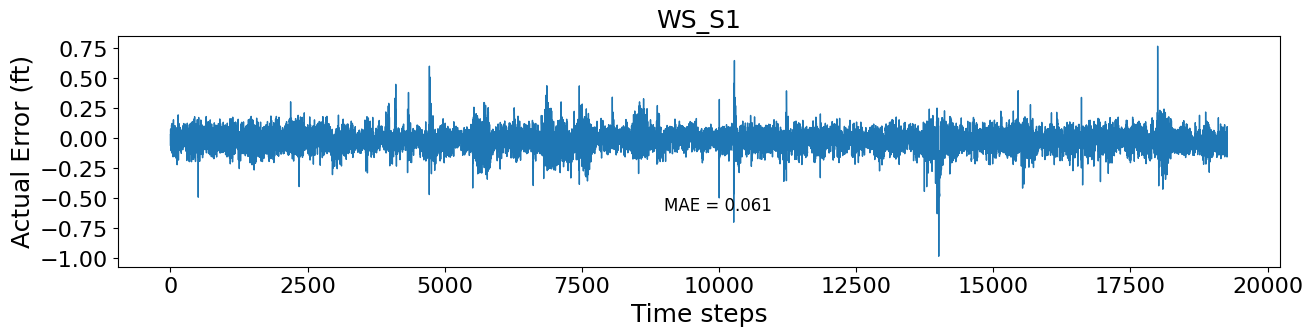

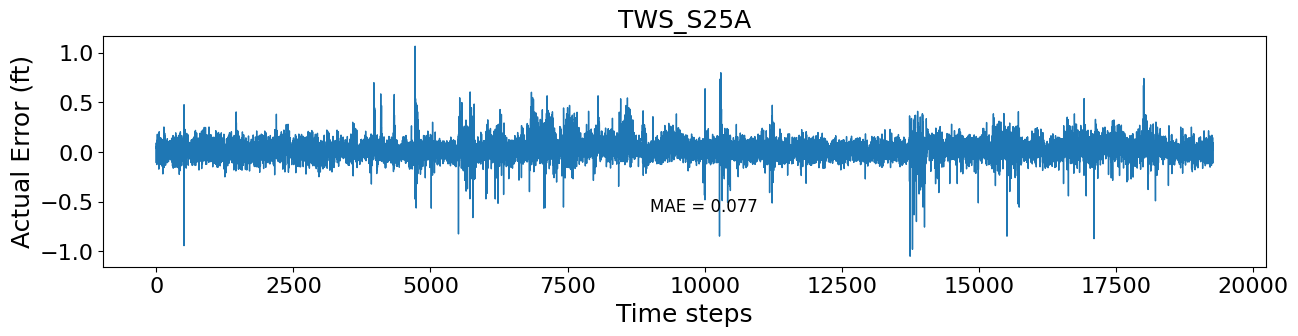

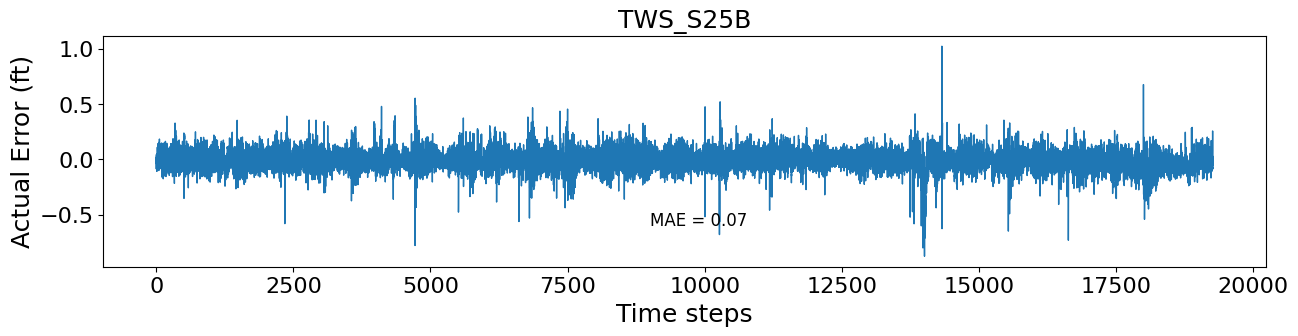

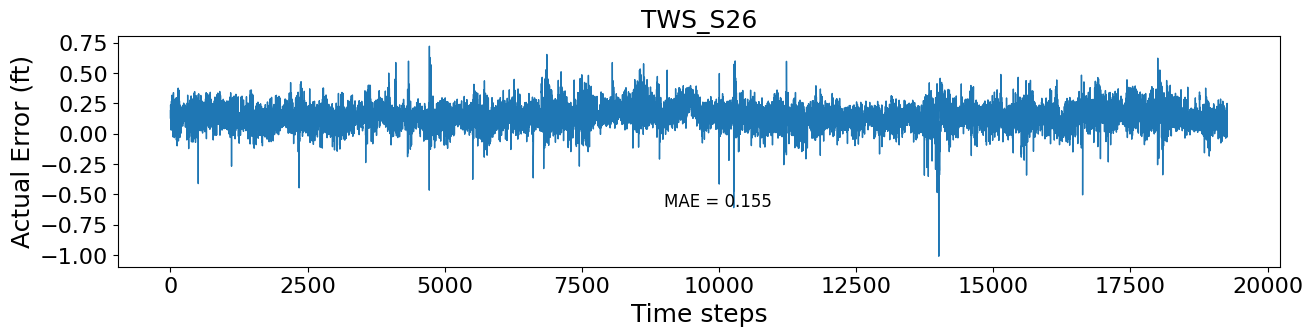

In [15]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [16]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
11
(19268,)
63
(19268,)
34
(19268,)
34


In [17]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
5
(19268,)
37
(19268,)
6
(19268,)
28


In [18]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
6
(19268,)
26
(19268,)
28
(19268,)
6
